<a href="https://colab.research.google.com/github/umaixer/DataScience-ML/blob/master/NLP/Sentiment%20Analysis%20with%20BERT%20using%20Pytorch/Sentiment_Analysis_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTIMENT ANALYSIS OF 50K IMDB MOVIE REVIEWS

**Problem Statement:**
We have to predict whether a review is positive or negative based on the review text using a classification model.

I am buiding a classifier using BERT model with Pytorch. I will use pre-trained BERT model (implemented by HuggingFace). We will see that this cutting edge algorithm will produce exceptional results.

Importing necessary libraries

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Importing the dataset**

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


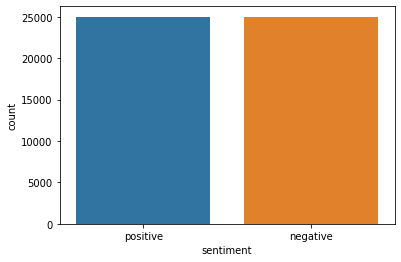

In [4]:
df.info
sns.countplot(df.sentiment)

We can see that dataset is almost perfectly balanced, therefore, no need of augmentation

### **Preprocessing and cleaning the data**

In [5]:
# Converting the labels to binary integers
df.sentiment = df.sentiment.apply(
    lambda x: 1 if x == "positive" else 0)

In [6]:
def remove_URL(text):
    return re.sub(r'https?://\S+|www\.\S+', '',text)

# Remove square brackets
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Remove html tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)
remove_html("<h1>Vansh Jatana</h1>")

#remove the noisy text
def remove_noise(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_html(text)
    return text

#Apply the remove_noise function 
df['review'] = df['review'].apply(remove_noise)

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


We can see that data is somewhat cleaned and html tags, brackets are removed.

**Defining and downloading BERT Tokenizer.**

In [8]:
tokenizer= transformers.BertTokenizer.from_pretrained('bert-base-uncased', 
                                                       do_lower_case=True)

**Building Pytorch DataSet**

In [9]:
class IMDB_dataset(Dataset):

    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          truncation=True,
          return_tensors='pt',
    )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
    }

Splitting the dataset into train(80%), validation(10%) and test(10%) data.

In [10]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=42
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=42
)


In [11]:
df_train.shape

(45000, 2)

Helper function for Pytorch dataloader is defined below

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = IMDB_dataset(reviews = df.review.to_numpy(),
                      labels = df.sentiment.to_numpy(),
                      tokenizer = tokenizer,
                      max_len = max_len)
    
    return DataLoader(ds, batch_size = batch_size, num_workers = 0)

Implementing DataLoader functions to make the data ready for training and evaluation

In [13]:
BATCH_SIZE = 16
MAX_LEN = 512
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
data = next(iter(train_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'labels'])

In [15]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


**Creating BERT model instance.**

In [16]:
bert_model = BertModel.from_pretrained('bert-base-uncased')


**Model Architecture**

In [17]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Building the classifier which used the BERT model.

In [18]:
class BERTmodel(nn.Module):
    def __init__(self):
        super(BERTmodel, self).__init__()
        self.bert = bert_model
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768,1)
    
    def forward(self, ids, mask):
        _, pooled_output = self.bert(ids, attention_mask = mask)                             
        bert_out = self.bert_drop(pooled_output)
        output = self.out(bert_out)
        
        return output

The classifier delegates most of the work to the pre-traiend Bert model. I added the dropout layer for some regularization to avoid over-fitting to the training data and a fully-connected layer for the binary output. 

**Defining the Loss function**

In [19]:
def loss_fn(outputs, labels):
    return nn.BCEWithLogitsLoss()(outputs, labels)

**Helper function for training our model is defined**

In [20]:
def train_fun(data_loader, model, optimizer, scheduler, device, n_examples):
    
    model = model.train()
    tr_losses = []
    tr_correct_preds = 0
    
    for step, data in enumerate(data_loader):
        
        input_ids = data["input_ids"].to(device)
        mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            ids = input_ids,
            mask = mask)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = loss_fn(outputs, labels)
        preds = torch.sigmoid(outputs)
        preds = outputs.detach().cpu().numpy()
        preds = (preds >= 0.5)*1
        labels = labels.detach().cpu().numpy()
        tr_correct_preds += np.sum(preds == labels)
        tr_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    return tr_correct_preds/n_examples, np.mean(tr_losses)

**Helper function for evaluating the model**

In [21]:
def eval_fun(data_loader, model, device, n_examples):
    model.eval()
    
    eval_losses = []
    eval_correct_preds = 0
    
    with torch.no_grad():
      for step, data in enumerate(data_loader):
          
          input_ids = data["input_ids"].to(device)
          mask = data["attention_mask"].to(device)
          labels = data["labels"].to(device)
          
          outputs = model(
              ids = input_ids,
              mask = mask)
          labels = labels.unsqueeze(1)
          labels = labels.float()
          loss = loss_fn(outputs, labels)
          preds = torch.sigmoid(outputs)
          preds = outputs.detach().cpu().numpy()
          preds = (preds >= 0.5)*1
          labels = labels.detach().cpu().numpy()
          eval_correct_preds += np.sum(preds == labels)
          eval_losses.append(loss.item())
    return  eval_correct_preds/n_examples, np.mean(eval_losses)  
    

## **Training**
Using the training and evaluation functions, we will implement the training loop.

ADAMW optimizer is utilized as it impelements the weight decay and produce better results.

In [22]:
EPOCHS =4
model = BERTmodel()
model = model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.Weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0}]


optimizer = AdamW(optimizer_parameters, lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
history = defaultdict(list)


for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    tr_acc, tr_loss = train_fun(train_loader, model, 
                                optimizer, scheduler, device, len(df_train))
    
    print('Training Loss: ' +str(tr_loss) +' Training Accuracy: ' +str(tr_acc*100) +'%')
    
    val_acc, val_loss= eval_fun(val_loader, model, 
                                device, len(df_val))
    
    print('Validation Loss: ' +str(val_loss) +' Validation Accuracy: ' +str(val_acc*100) +'%')

    history['tr_acc'].append(tr_acc)
    history['tr_loss'].append(tr_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epoch 1/4
----------
Training Loss: 0.2056743017575941 Training Accuracy: 91.51555555555557%
Validation Loss: 0.15314603562520188 Validation Accuracy: 94.16%
Epoch 2/4
----------
Training Loss: 0.09480840640312733 Training Accuracy: 96.64444444444445%
Validation Loss: 0.158085762969497 Validation Accuracy: 94.36%
Epoch 3/4
----------
Training Loss: 0.0425142275097565 Training Accuracy: 98.69777777777777%
Validation Loss: 0.193786721061144 Validation Accuracy: 94.64%
Epoch 4/4
----------
Training Loss: 0.019705833418291806 Training Accuracy: 99.49333333333334%
Validation Loss: 0.23891529305741654 Validation Accuracy: 94.28%


### **Training Model Analysis**

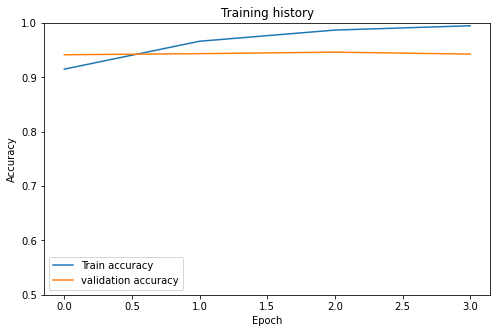

In [54]:
plt.figure(figsize = (8,5))
plt.plot(history['tr_acc'], label='Train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);


## **Evaluation**

In [29]:
test_acc, test_loss= eval_fun(test_loader, model, 
                                device, len(df_test))

### **Test Accuracy**

In [32]:
print('Test Accuracy: ' +str(test_acc*100) +'%')

Test Accuracy: 94.8%


**Defining the prediction function**

In [37]:
def pred_fun(data_loader, model):
    model.eval()
    
    targets = []
    predictions = []
    
    with torch.no_grad():
      for step, data in enumerate(data_loader):
          
          input_ids = data["input_ids"].to(device)
          mask = data["attention_mask"].to(device)
          labels = data["labels"].to(device)
          
          outputs = model(
              ids = input_ids,
              mask = mask)
          preds = torch.sigmoid(outputs)
          preds = outputs.detach().cpu().numpy()
          preds = (preds >= 0.5)*1
          labels = labels.detach().cpu().numpy()
          predictions.extend(preds)
          targets.extend(labels)

    predictions = np.stack(predictions)
    targets = np.stack(targets)
    return  predictions, targets 

In [38]:
y_pred, y_test = pred_fun(test_loader, model)

### **Classification report including the F1 score**

In [53]:
print(classification_report(y_test, y_pred, target_names = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.94      0.95      0.95      1232
    negative       0.95      0.94      0.95      1268

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



### **Confusion Matrix**

[[1174   58]
 [  72 1196]]


Text(69.0, 0.5, 'Predicted')

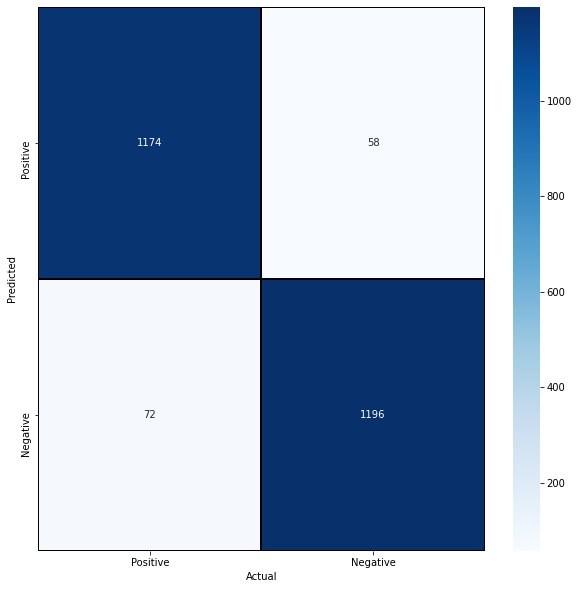

In [47]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", xticklabels = ['Positive','Negative'], 
           yticklabels = ['Positive','Negative'],
           linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')

95% test accuracy as well as precision proves that pre-trained BERT model has exceptional performance. 